In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [42]:
# Load data in as a pandas DF
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [43]:
# Get a preview of the data
data.head()

# Each row corresponds to one example, and each example has 784 pixel values and a label

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Convert pandas DF to np array to perfrom lin alg
data = np.array(data)

# Get the dimensions of the data (m = num of examples, n = amount of features (pixels) plus 1)
m, n = data.shape

# Shuffle our data
np.random.shuffle(data) 

# Cross-validation data that we'll set aside
data_dev = data[0:1000].T
Y_dev = data_dev[0]   # label (first row)
X_dev = data_dev[1:n] # pixel values (remaining rows)
X_dev = X_dev / 255.  # each pixel has value 0 to 255, so divide by 255 to get 0 to 1 (float)

# Training data (rest of the examples)
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255. 
_,m_train = X_train.shape

In [45]:
def init_params():
    """Sets up our weight and bias matrices for layer 1 and 2"""
    
    # gives us our weights for the first hidden layer (10 x 784)
    W1 = np.random.rand(10, 784) - 0.5
    
    # gives us our bias for each weight (10 x 1)
    b1 = np.random.rand(10, 1) - 0.5
    
    # gives us our weights for the second hidden layer (10 x 10)
    W2 = np.random.rand(10, 10) - 0.5
    
    # gives us our bias for each weight (10 x 1)
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

In [46]:
def ReLU(Z):
    """ReLU activation function.
    
    Arguments:
    Z -- layer matrix
    """
    
    # Go through each element in Z, if x > 0 return x, else return 0
    return np.maximum(Z, 0)

def softmax(Z):
    """Softmax activation function.
    
    Arguments:
    Z -- layer matrix
    """
    
    # e^z for every value and divide by sum through each column 
    # (preserve columns, collapse rows to sum for each column)
    A = np.exp(Z) / sum(np.exp(Z))
    return A


def forward_prop(W1, b1, W2, b2, X):
    """Forward propagation.
    
    Arguments:
    W1 -- layer 1 weight parameters
    b1 -- layer 1 bias parameters
    W2 -- layer 2 weight parameters
    b2 -- layer 2 bias parameters
    X -- input matrix
    """
    
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def one_hot(Y):
    """One-hot encodes labels.
    
    Arguments:
    Y -- labels
    """
    
    # Create matrix (m x 10) init with zeros => num examples by num classes
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    
    # For each row, go to the column specified by the label and set it equal to 1
    one_hot_Y[np.arange(Y.size), Y] = 1
    
    # Flip so that each col is an example
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y
    
    
def ReLU_deriv(Z):
    """Takes the derivative of ReLU.
    
    Arguments:
    Z -- layer matrix
    """
    
    return Z > 0
    
    
def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    """Backpropagation.
    
    Arguments:
    Z1 -- hidden layer 1
    A1 -- activation for layer 1
    Z2 -- output layer 2
    A2 -- activation for layer 2
    W2 -- layer 2 weights
    X -- input matrix
    Y -- labels
    """
    
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2


def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """Update our weight and bias parameters.
    
    Arguments:
    W1 -- original layer 1 weight matrix
    b1 -- original layer 1 bias matrix
    W2 -- original layer 2 weight matrix
    b2 -- original layer 2 bias matrix
    dW1 -- how much each weight 1 contributed to error
    db1 -- how much each bias 1 contributed to error
    dW2 -- how much each weight 2 contributed to error
    db2 -- how much each bias 2 contributed to error
    alpha -- learning rate hyperparameter
    """
    
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    
    return W1, b1, W2, b2

In [47]:
def get_predictions(A2):
    """Get predictions based on application of softmax in forward prop.
    
    Arguments:
    A2 -- softmax matrix
    """
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    """Get the accuracy based on predictions and ground-truth labels.
    
    Arguments:
    predictions -- predictions from the model
    Y -- ground truth labels
    """
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    """Perform gradient descent. Return the params that we want.
    
    Arguments:
    X -- input matrix
    Y -- labels
    iterations -- number of iterations to run for
    alpha -- learning rate hyperparameter
    """
    W1, b1, W2, b2 = init_params()
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Every 10th iteration, print an update
        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    
    return W1, b1, W2, b2
    

In [57]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.1)

Iteration:  0
[9 1 0 ... 1 0 1] [6 4 9 ... 1 3 1]
Accuracy:  0.09629268292682927
Iteration:  10
[0 9 5 ... 7 5 7] [6 4 9 ... 1 3 1]
Accuracy:  0.18451219512195122
Iteration:  20
[0 9 7 ... 7 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.25665853658536586
Iteration:  30
[0 9 7 ... 7 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.2952439024390244
Iteration:  40
[0 9 7 ... 7 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.3328536585365854
Iteration:  50
[0 9 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.37658536585365854
Iteration:  60
[0 9 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.4243658536585366
Iteration:  70
[6 9 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.4693414634146341
Iteration:  80
[6 9 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.5135121951219512
Iteration:  90
[6 9 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.5510487804878049
Iteration:  100
[6 9 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.5820731707317073
Iteration:  110
[6 4 7 ... 1 7 1] [6 4 9 ... 1 3 1]
Accuracy:  0.6109756097560975
Iteration:  120
[6 4 7 

In [58]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [6]
Label:  6


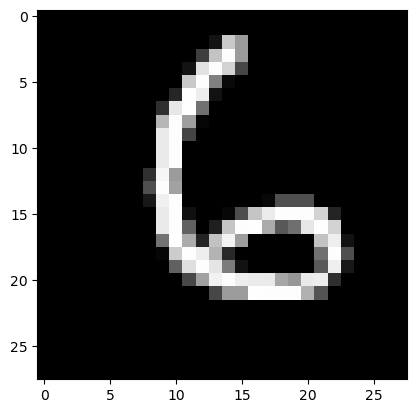

Prediction:  [4]
Label:  4


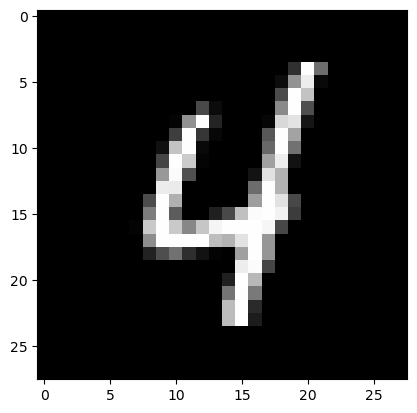

Prediction:  [9]
Label:  9


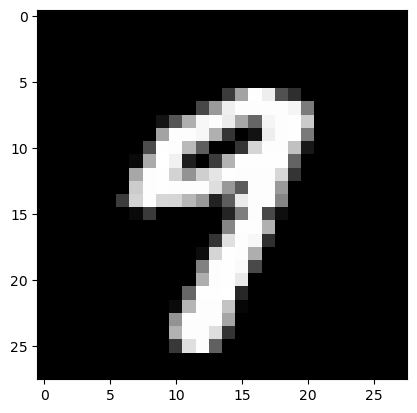

Prediction:  [4]
Label:  4


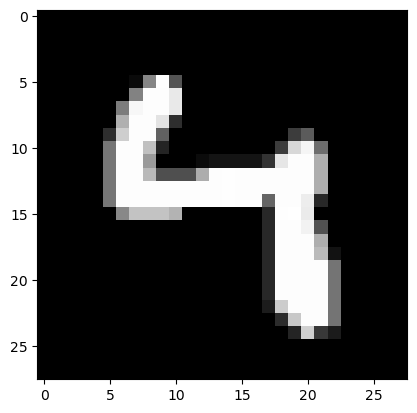

In [59]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)